## Classify Spikes into early and late theta phase precession

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

[2025-02-06 15:05:13,817][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-02-06 15:05:13,858][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [470]:
import matplotlib
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import (ThetaIntervals,TrialChoice,TrialChoiceChangeOfMind,
        RippleTimes,TetrodeNumber,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode)
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,find_spikes
                            )
from spyglass.shijiegu.singleUnit_sortedDecode import place_field_direction
from spyglass.shijiegu.fragmented import permute_frag_cont,find_spike_count_ratio,get_nwb_units,classify_cells,find_firing_cross_correlation
from spyglass.shijiegu.placefield import cell_by_arm
from spyglass.shijiegu.theta import theta_parser_master

from spyglass.shijiegu.changeOfMind_triggered import turnaround_triggered_position
from spyglass.shijiegu.singleUnit_thetaPhase import triggered_theta_mua_animal, find_nearby_trial_time

In [584]:
animal = "eliot" #"lewis"# "eliot"
list_of_days = ["20221021"] #["20240109"] #["20221021"]

In [585]:
def process_theta_nwb_copy_file_name(nwb_copy_file_name, curation_id = 1):
    # run theta_parser_master() for all days
    # epoch is the epoch ID
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)
    
    for ind in range(len(run_session_names)):
        session_name = run_session_names[ind]
        position_name = pos_session_names[ind]
        print(session_name)

        query = ThetaIntervals() & {'nwb_file_name': nwb_copy_file_name,
                    'interval_list_name': session_name}
        if len(query) > 0:
            continue
    
        # get cell spiking data 
        (cells, smoothed_placefield, placefield_peak,
                spike_count_by_arm_direction, betaPdfs, means) = place_field_direction(nwb_copy_file_name,
                                                                                       session_name,position_name,
                                                                                       curation_id = curation_id)
                                                                                      
        sort_group_ids = np.unique((Curation() & {'nwb_file_name': nwb_copy_file_name,
                                              "curation_id":curation_id}).fetch("sort_group_id"))
        nwb_units_all = get_nwb_units(
            nwb_copy_file_name,session_name,sort_group_ids,curation_id = 1)
    
        theta_parser_master(nwb_copy_file_name,
                        position_name, session_name,
                        nwb_units_all,cells)

In [436]:
process_theta_nwb_copy_file_name('eliot20221021_.nwb', curation_id = 1)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221021_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221021_ 2         02_Seq2Session pos 1 valid ti
eliot20221021_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221021_ 4         04_Seq2Session pos 3 valid ti
eliot20221021_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221021_ 6         06_Seq2Session pos 5 valid ti
eliot20221021_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221021_ 8         08_Seq2Session pos 7 valid ti
eliot20221021_ 9         09_Seq2Sleep5  pos 8 valid ti
 (Total: 9)

02_Seq2Session1


[12:07:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:07:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:07:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:07:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:07:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackG

parsing thetas cycle by cycle.
Done parsing thetas cycle by cycle.
Done inserting into Spyglass.
04_Seq2Session2


[12:17:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:17:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:17:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:17:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:17:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackG

parsing thetas cycle by cycle.
Done parsing thetas cycle by cycle.
Done inserting into Spyglass.
06_Seq2Session3


[12:23:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:23:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:23:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:23:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:23:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackG

parsing thetas cycle by cycle.
Done parsing thetas cycle by cycle.
Done inserting into Spyglass.
08_Seq2Session4


[12:30:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:30:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:30:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:30:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[12:30:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackG

parsing thetas cycle by cycle.
Done parsing thetas cycle by cycle.
Done inserting into Spyglass.


In [586]:
late_theta, early_theta, late_theta_nearby, early_theta_nearby = triggered_theta_mua_animal(animal, list_of_days)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221021_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221021_ 2         02_Seq2Session pos 1 valid ti
eliot20221021_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221021_ 4         04_Seq2Session pos 3 valid ti
eliot20221021_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221021_ 6         06_Seq2Session pos 5 valid ti
eliot20221021_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221021_ 8         08_Seq2Session pos 7 valid ti
eliot20221021_ 9         09_Seq2Sleep5  pos 8 valid ti
 (Total: 9)



[14:42:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[14:42:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[14:42:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[14:42:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[14:42:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackG

### figure version 1

(0.0, 200.0)

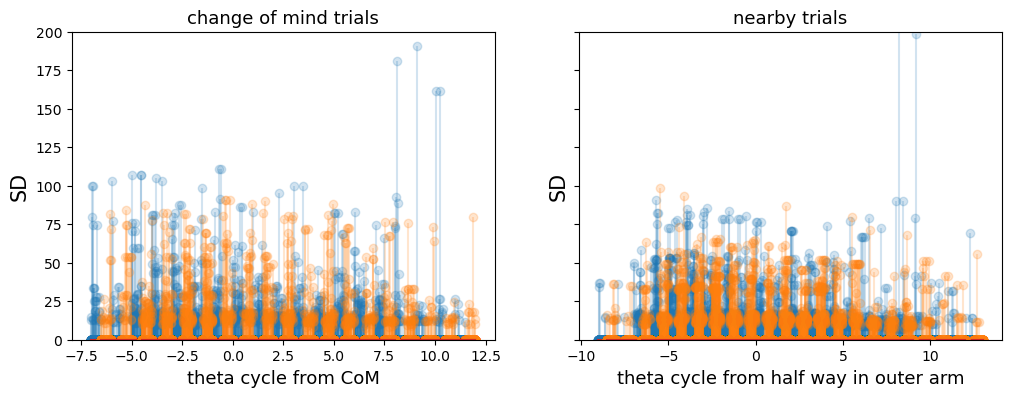

In [588]:
fig,axes=plt.subplots(1,2,figsize=(12, 4),sharey=True)


for firing_matrix_early_theta in early_theta:
    t = firing_matrix_early_theta.index
    for c in firing_matrix_early_theta.columns:
        y = firing_matrix_early_theta[c]
        if np.nanmax(y) <= 0.5:
            continue
      
        markerline, stemlines, baseline = axes[0].stem(t, y)
        stemlines.set_alpha(0.2)
        markerline.set_alpha(0.2)

for firing_matrix_early_theta in late_theta:
    t = firing_matrix_early_theta.index
    for c in firing_matrix_early_theta.columns:
        y = firing_matrix_early_theta[c]
        if np.nanmax(y) <= 0.5:
            continue
      
        markerline, stemlines, baseline = axes[0].stem(t, y, linefmt= "C1")
        stemlines.set_alpha(0.2)
        markerline.set_alpha(0.2)

axes[0].set_title("change of mind trials",fontsize = 13)
axes[0].set_ylabel("SD",fontsize = 15)
axes[0].set_xlabel("theta cycle from CoM",fontsize = 13)
#axes[0].text(-12, 0, animal,fontsize = 15)

for firing_matrix_early_theta in early_theta_nearby:
    t = firing_matrix_early_theta.index
    for c in firing_matrix_early_theta.columns:
        y = firing_matrix_early_theta[c]
        if np.nanmax(y) <= 0.5:
            continue
      
        markerline, stemlines, baseline = axes[1].stem(t, y)
        stemlines.set_alpha(0.2)
        markerline.set_alpha(0.2)

for firing_matrix_early_theta in late_theta_nearby:
    t = firing_matrix_early_theta.index
    for c in firing_matrix_early_theta.columns:
        y = firing_matrix_early_theta[c]
        if np.nanmax(y) <= 0.5:
            continue
      
        markerline, stemlines, baseline = axes[1].stem(t, y, linefmt= "C1")
        stemlines.set_alpha(0.2)
        markerline.set_alpha(0.2)

axes[1].set_title("nearby trials",fontsize = 13)
axes[1].set_ylabel("SD",fontsize = 15)
axes[1].set_xlabel("theta cycle from half way in outer arm",fontsize = 13)

axes[1].set_ylim([0,200])
#axes[1].text(-12, 0, animal,fontsize = 15)

### Figure version 2

In [615]:
def smoothen(arr, window_size = 20):
    # fills nan with 0 then smoothens
    mean_filled = np.nan_to_num(arr, nan=0)

    weights = np.ones(window_size) / window_size
    mean_smooth = np.convolve(mean_filled, weights, mode='same')

    return mean_smooth


In [616]:
# get mean traces
df1 = early_theta[0]
df2 = late_theta[0]
for early_theta_ in early_theta:
    if len(early_theta_) >= len(df1):
        df1 = early_theta_

for late_theta_ in late_theta:
    if len(late_theta_) >= len(df2):
        df2 = late_theta_
        
t_axis = np.sort(np.concatenate((np.array(df1.index),np.array(df2.index))))

def concatenate_pd(t_axis, early_theta):
    # early_theta is a list of data frames that share common t-axis
    
    early_theta_imshow = []
    for firing_matrix_early_theta in early_theta:
        M = np.zeros((len(firing_matrix_early_theta.columns), len(t_axis))) + np.nan
        _, ind1, ind2 = np.intersect1d(t_axis, np.array(firing_matrix_early_theta.index), return_indices=True)
        for c in firing_matrix_early_theta.columns:
            M[c,ind1] = np.array(firing_matrix_early_theta[c])[ind2]
        early_theta_imshow.append(M)
    early_theta_imshow = np.concatenate(early_theta_imshow) # (neuron x sessionnumber) x time
    return early_theta_imshow

In [617]:
def smoothen_mean_std(early_theta_imshow):
    # return variables for plotting
    mean = np.nanmean(early_theta_imshow, axis = 0)
    mean_smooth = smoothen(mean)
    
    std1 = np.nanstd(early_theta_imshow, axis = 0)
    std1 = 2*smoothen(std1)

    return mean_smooth, mean_smooth - std1, mean_smooth + std1

(-3.0, 3.0)

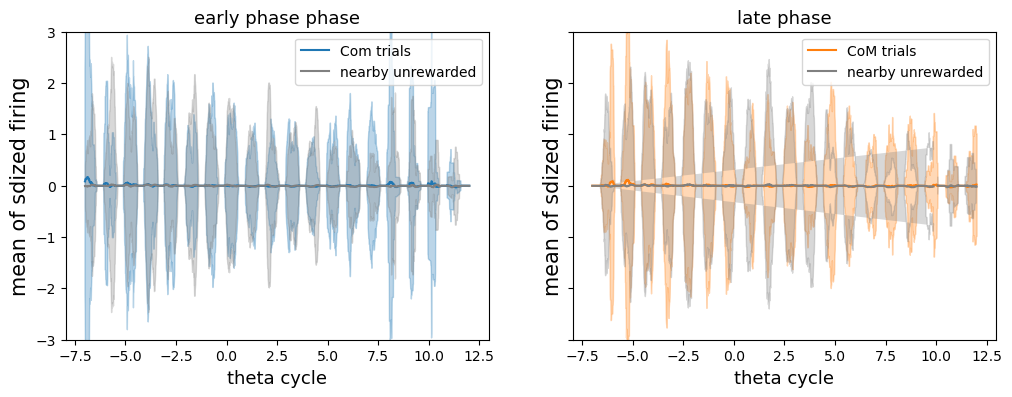

In [626]:
fig,axes=plt.subplots(1,2,figsize=(12, 4),sharey=True)

early_theta_imshow = concatenate_pd(t_axis, early_theta)
y, y0, y1 = smoothen_mean_std(early_theta_imshow)

axes[0].plot(t_axis, y, label = "Com trials", color = "C0")
axes[0].fill_between(t_axis, y0, y1, alpha=0.3, color='C0')

early_theta_imshow_neaby = concatenate_pd(t_axis, early_theta_nearby)
y, y0, y1 = smoothen_mean_std(early_theta_imshow_neaby)

axes[0].plot(t_axis, y, label = "nearby unrewarded", color = "grey")
axes[0].fill_between(t_axis, y0, y1, alpha=0.3, color='grey')
axes[0].set_title("early phase phase",fontsize = 13)
axes[0].set_ylabel("mean of sdized firing",fontsize = 15)
axes[0].set_xlabel("theta cycle",fontsize = 13)
axes[0].legend()


early_theta_imshow = concatenate_pd(t_axis, late_theta)
y, y0, y1 = smoothen_mean_std(early_theta_imshow)

axes[1].plot(t_axis, y, label = "CoM trials", color = "C1")
axes[1].fill_between(t_axis, y0, y1, alpha=0.3, color='C1')


early_theta_imshow = concatenate_pd(t_axis, late_theta_nearby)
y, y0, y1 = smoothen_mean_std(early_theta_imshow)

axes[1].plot(t_axis, y, label = "nearby unrewarded", color = "grey")
axes[1].fill_between(t_axis, y0, y1, alpha=0.3, color='grey')


axes[1].set_title("late phase",fontsize = 13)
axes[1].set_ylabel("mean of sdized firing",fontsize = 15)
axes[1].set_xlabel("theta cycle",fontsize = 13)
axes[1].legend()
axes[1].set_ylim([-3,3])



# End here

### 2. Load theta phase and position

In [553]:
from spyglass.shijiegu.load import load_theta_maze
from spyglass.shijiegu.Analysis_SGU import get_linearization_map,segment_to_linear_range
from spyglass.shijiegu.theta import return_skaggs_theta, return_theta_phase_location

import xarray as xr
import scipy

In [554]:
theta_df, pos1d, pos2d = return_skaggs_theta(nwb_copy_file_name,pos_name,session_name,
                                             nwb_units_all,cell_list)
linear_map, welllocations = get_linearization_map()

NameError: name 'cell_list' is not defined

In [ ]:
# for inspection
# theta_xr_test = theta_xr.sel(time = slice(theta_xr.time[0],theta_xr.time[1000]))

# plt.plot(theta_xr_test.time,theta_xr_test[0]/100)
# plt.plot(theta_xr_test.time,np.cos(theta_xr_test['phase0']))

### 4. phase precession plot

In [83]:
from sklearn.linear_model import LinearRegression
def fit_theta_phase_location(pos_phase,arms):
    score = {}
    model = {}
    for direction in pos_phase.keys():
        x = pos_phase[direction][0]
        y = pos_phase[direction][1]
        if len(x) > 0:
            model[direction] = LinearRegression().fit(np.array(x).reshape((-1,1)), np.array(y).reshape((-1,1)))
            score[direction] = model[direction].score(np.array(x).reshape((-1,1)), np.array(y).reshape((-1,1)))
        else:
            score[direction] = np.nan
        
    return model,score

#### TO DO: do circular regression using complex number regression:

https://www.chrishenson.net/posts/2020-06-19-complex_regression.html

#### for one neuron

In [121]:
unitID = (13,7)
pos_phase,arms = return_theta_phase_location(pos1d,pos2d,theta_df,nwb_units_all,unitID)
model,score = fit_theta_phase_location(pos_phase,arms)

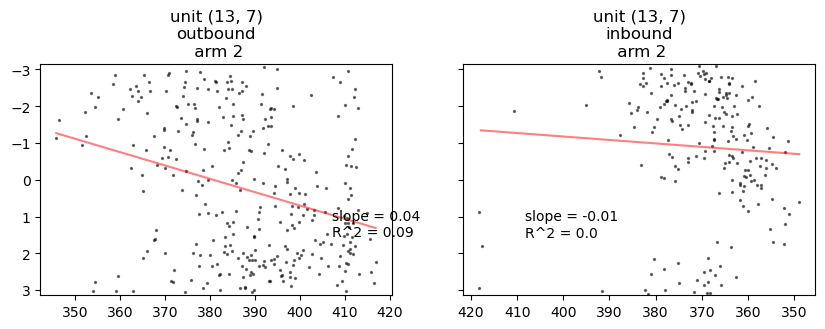

In [122]:
fig,axes=plt.subplots(1,2,figsize=(10,3),sharey= True)

ind = 0
for direction in pos_phase.keys():
    arm = arms[direction]
    axes[ind].set_title('unit ' + str(unitID) + '\n' +direction + '\n arm '+str(arm))
    x = pos_phase[direction][0]
    y = pos_phase[direction][1]
    
    axes[ind].scatter(x, y, s = 2, color = 'k', alpha = 0.5)
    axes[ind].set_ylim([-np.pi,np.pi])

    """do fitting"""
    x_ = np.arange(x.min(),x.max())
    y_ = model[direction].predict(x_.reshape(-1,1)).ravel()
    axes[ind].plot(x_, y_, color = 'red', alpha = 0.5)
    axes[ind].text(x.max()-10,0.5*y.max(),
                   "slope = " + str(round(model[direction].coef_[0][0],2))+"\n"+
                   "R^2 = " + str(round(score[direction],2)))
    
    if direction == 'inbound':
        axes[ind].invert_xaxis()
    axes[ind].invert_yaxis()
    
    ind += 1

In [112]:
def plot_theta_phase_precession(pos_phase,arms,model,score,unitID):
    
    fig,axes=plt.subplots(1,2,figsize=(10,3),sharey= True)

    ind = 0
    for direction in pos_phase.keys():
        arm = arms[direction]
        axes[ind].set_title('unit ' + str(unitID) + '\n' +direction + '\n arm '+str(arm))
        x = pos_phase[direction][0]
        y = pos_phase[direction][1]
        
        axes[ind].scatter(x, y, s = 2, color = 'k', alpha = 0.5)
        axes[ind].set_ylim([-np.pi,np.pi])
    
        """do fitting"""
        if len(x) > 2:
            x_ = np.arange(x.min(),x.max())
            if len(x_) > 2:
                y_ = model[direction].predict(x_.reshape(-1,1)).ravel()
                axes[ind].plot(x_, y_, color = 'red', alpha = 0.5)
                axes[ind].text(x.max()-10,0.5*y.max(),
                           "slope = " + str(round(model[direction].coef_[0][0],2))+"\n"+
                           "R^2 = " + str(round(score[direction],2)))
        #except:
        #    pass
        axes[ind].invert_yaxis()
        if direction == 'inbound':
            axes[ind].invert_xaxis()
        
        ind += 1

#### for many neurons

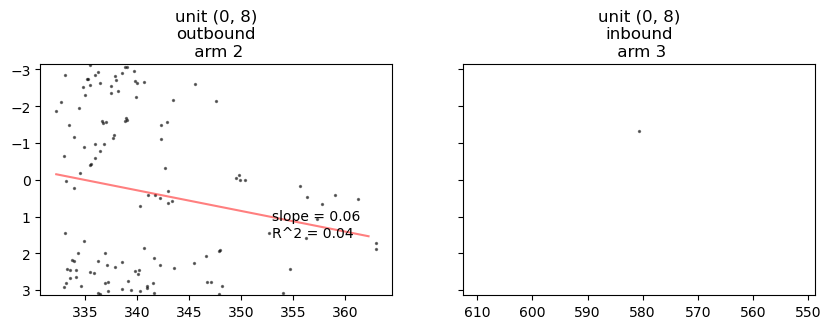

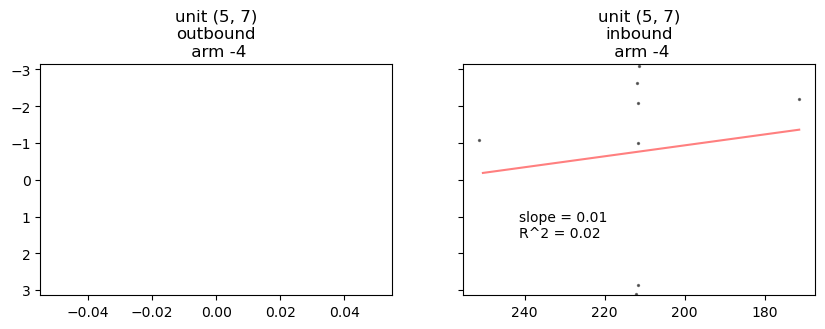

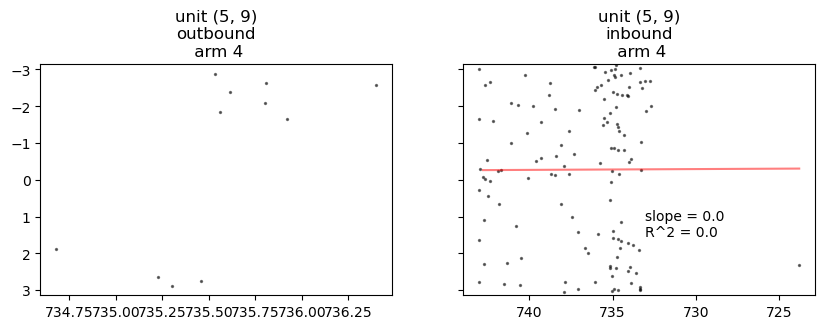

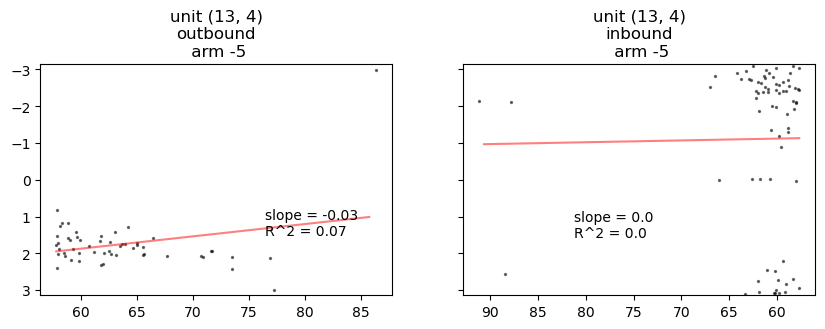

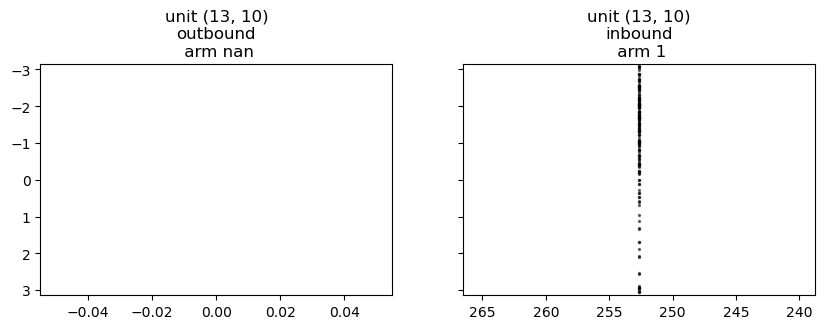

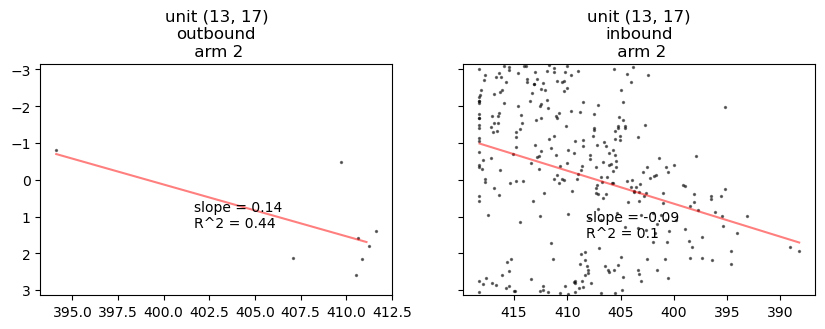

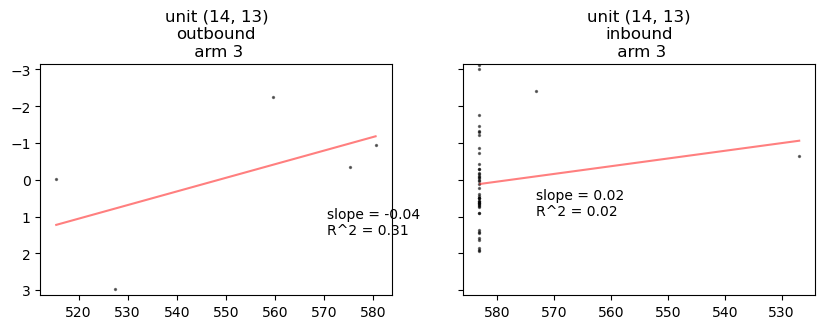

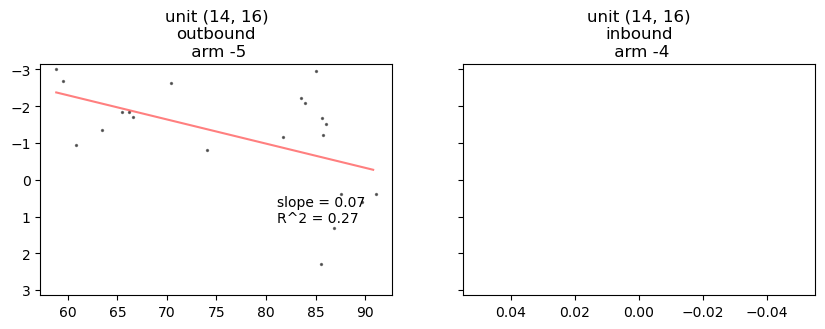

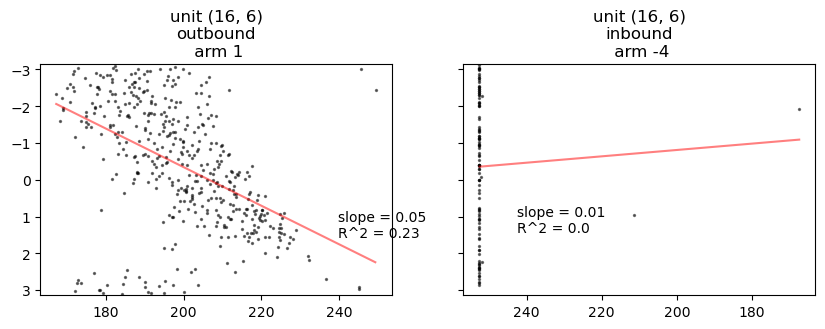

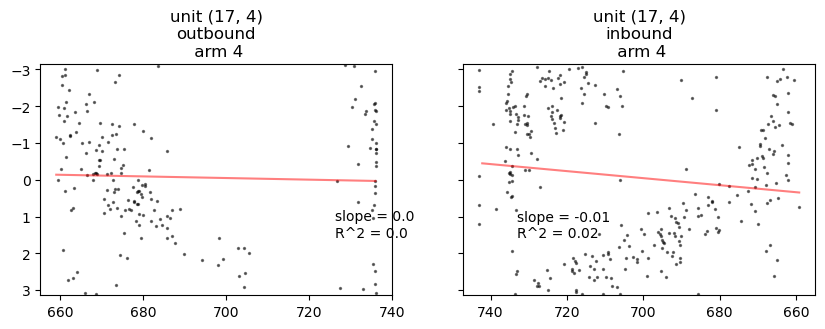

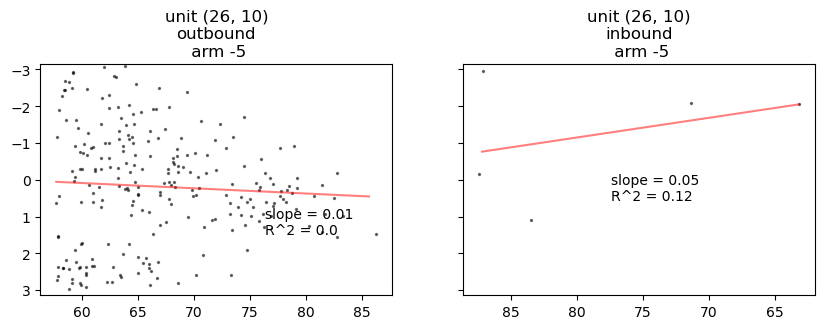

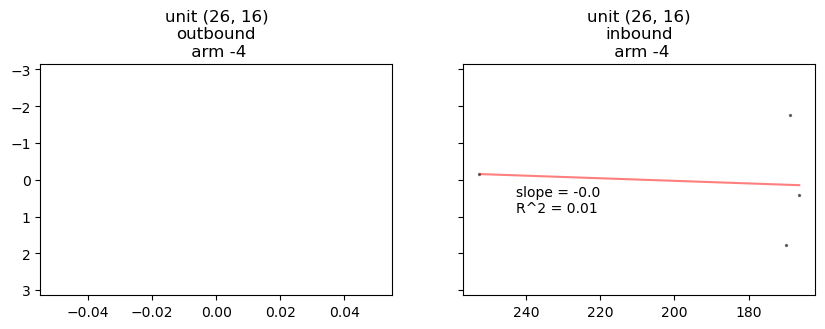

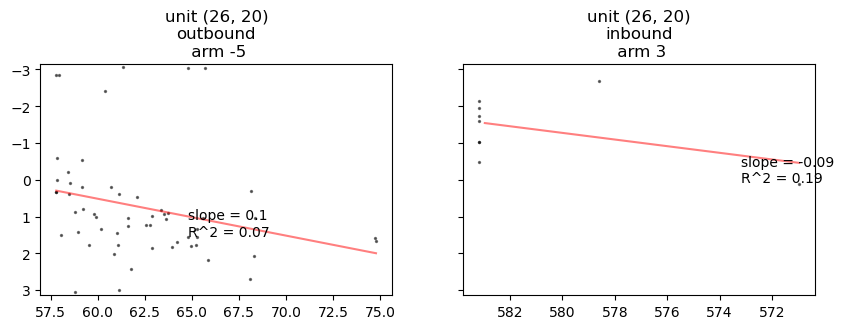

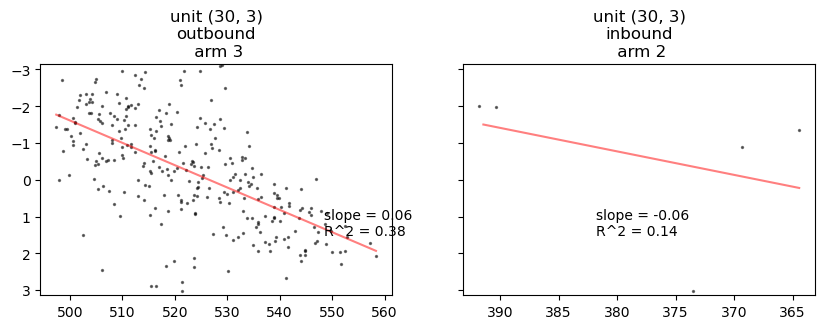

In [113]:
coef_all_frag = []
score_all_frag = []

for unitID in cells_frag:
    pos_phase,arms = return_theta_phase_location(pos1d,pos2d,theta_df,nwb_units_all,unitID)
    model,score = fit_theta_phase_location(pos_phase,arms)

    # find direction
    scores = np.array([score['outbound'],score['inbound']])
    if np.sum(np.isnan(scores)) == 2:
        continue
    direction = np.nanargmax(scores)
    if direction == 0:
        coef = model['outbound'].coef_[0][0]
    else:
        coef = -model['inbound'].coef_[0][0]
    
    score_all_frag.append(scores[direction])
    coef_all_frag.append(coef)

    # plot
    plot_theta_phase_precession(pos_phase,arms,model,score,unitID)


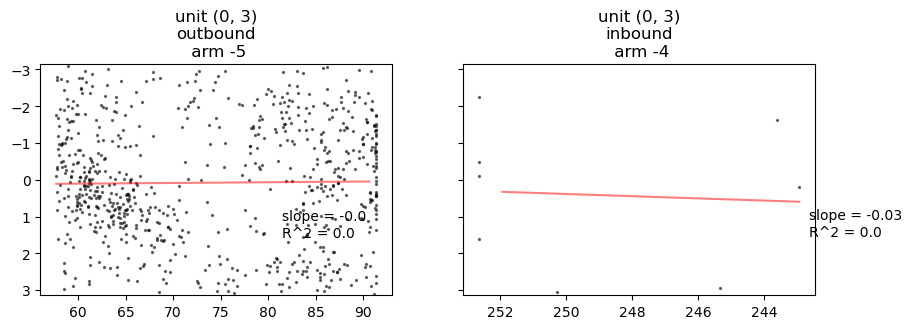

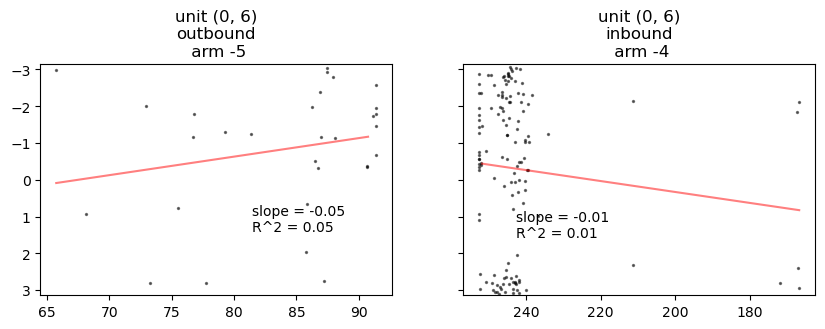

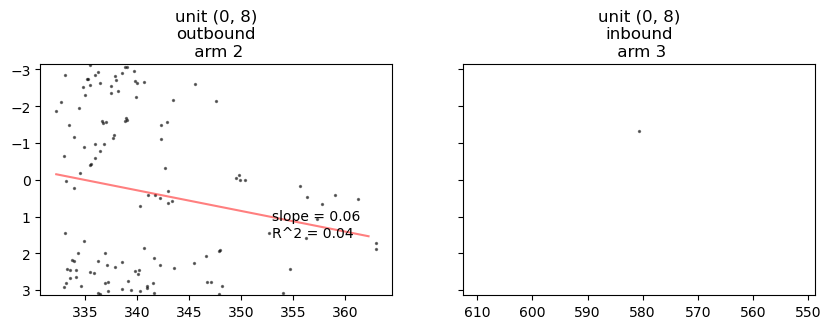

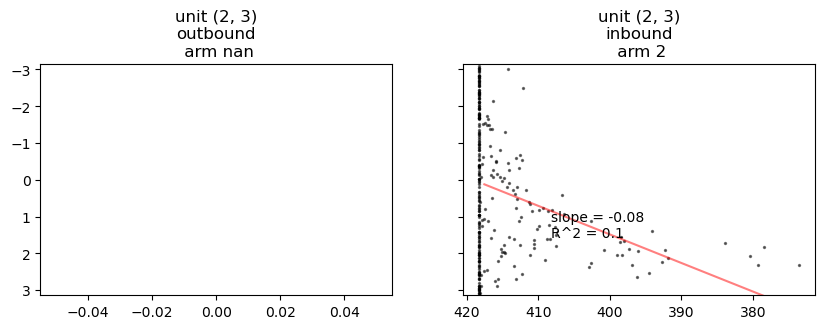

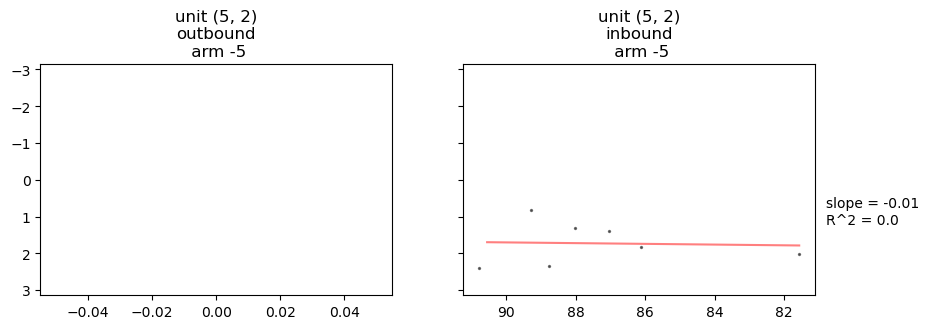

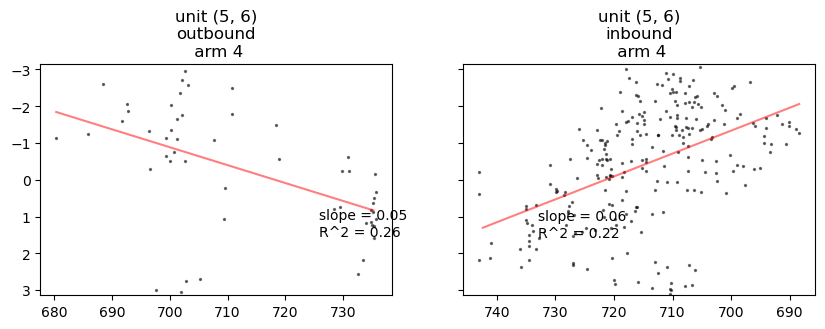

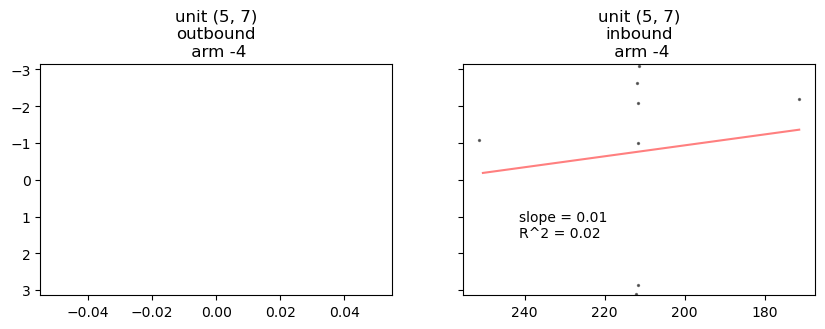

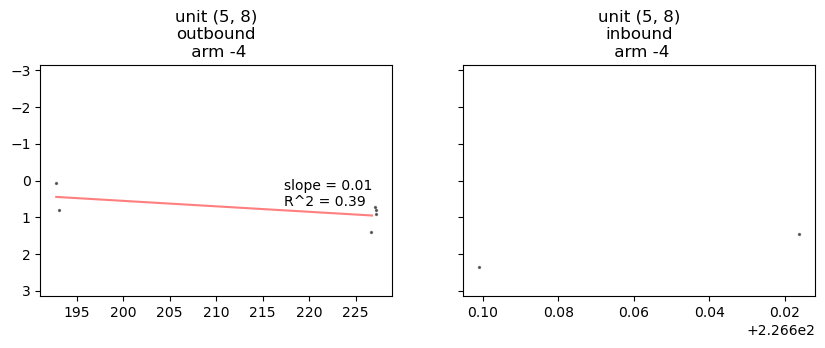

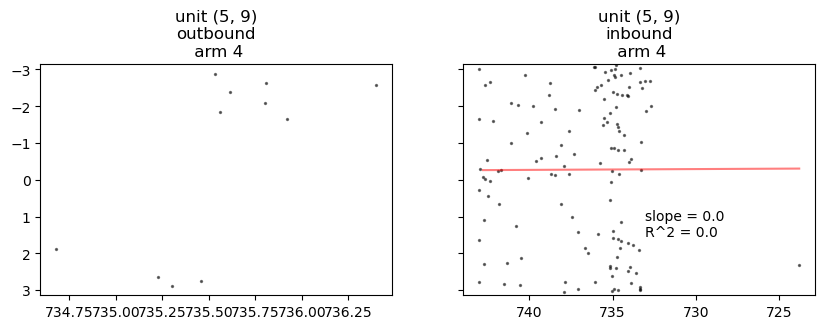

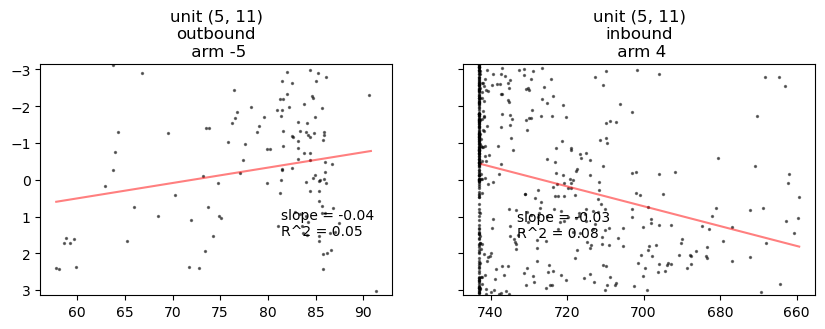

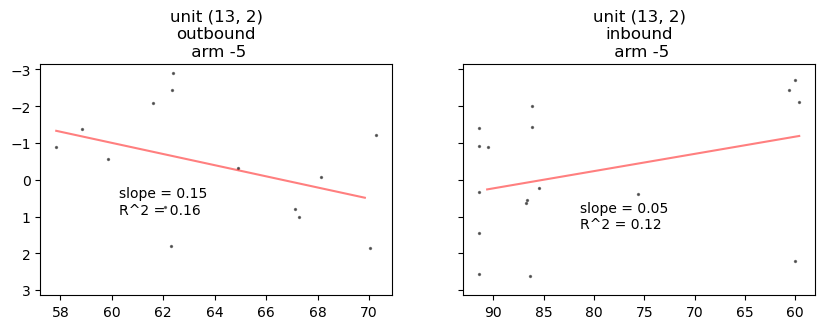

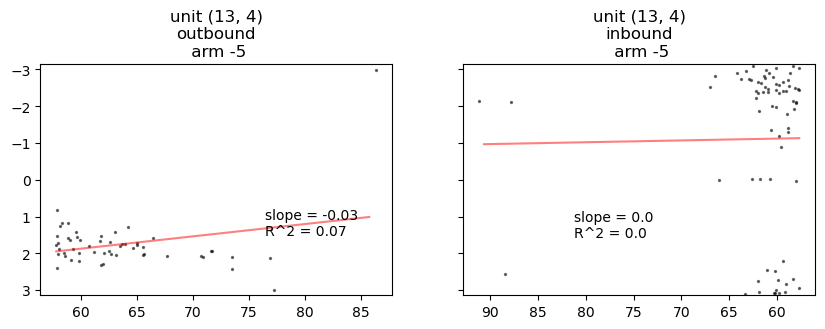

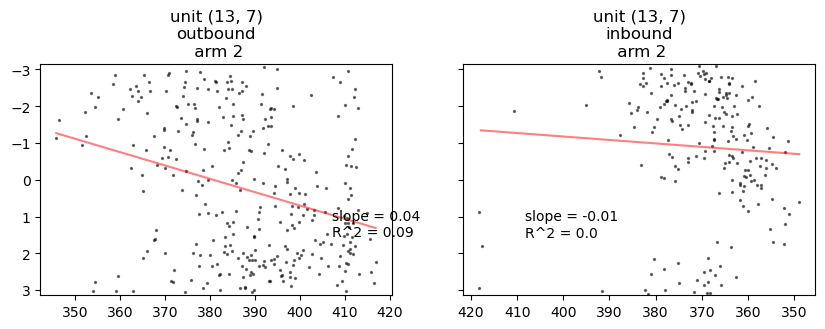

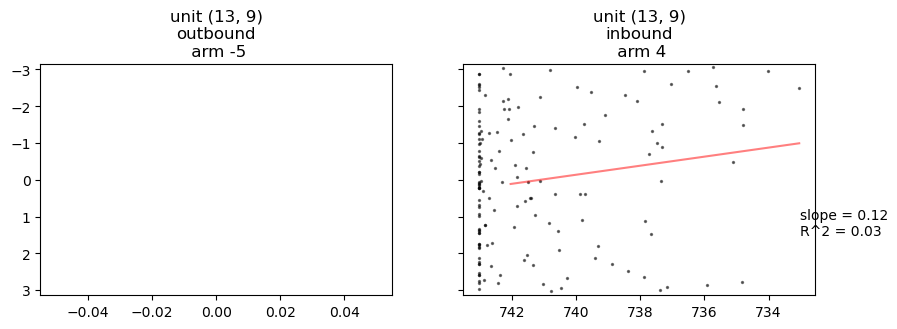

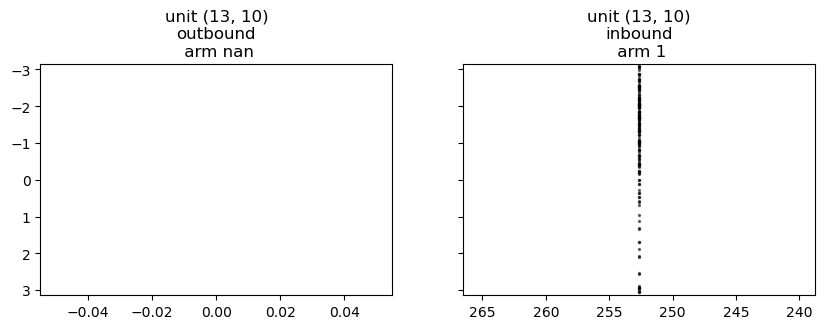

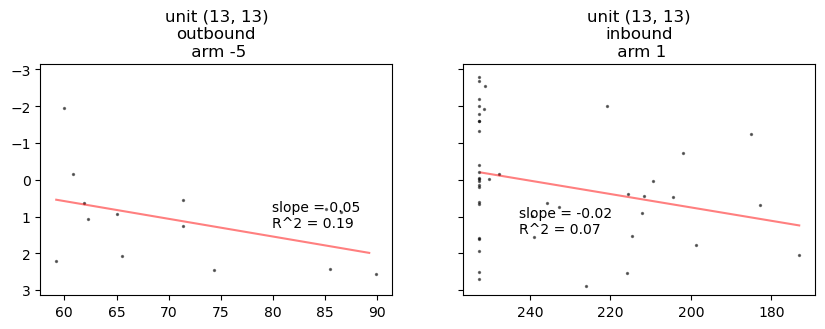

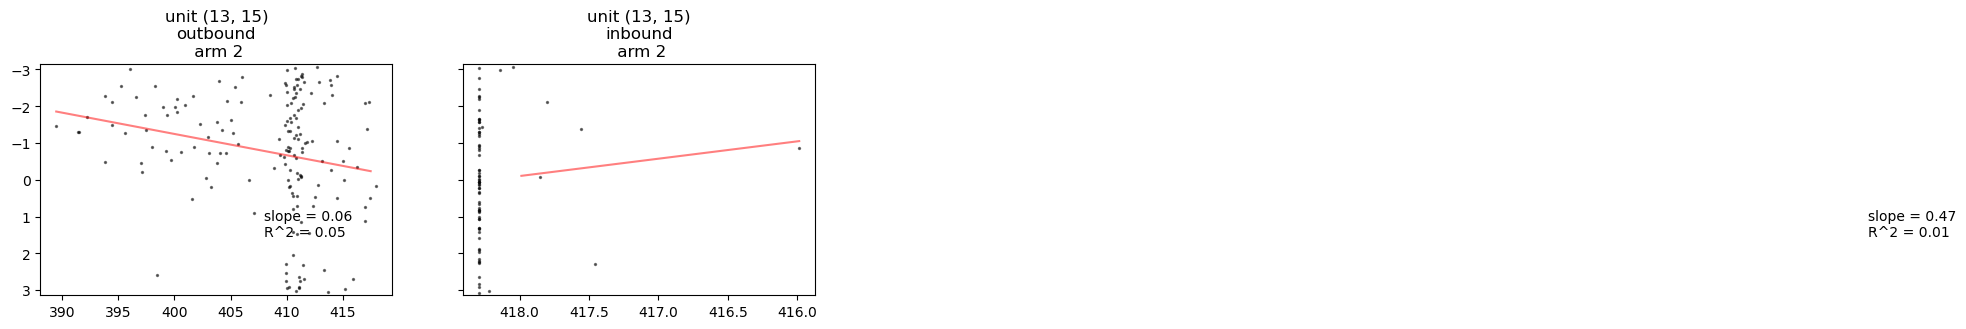

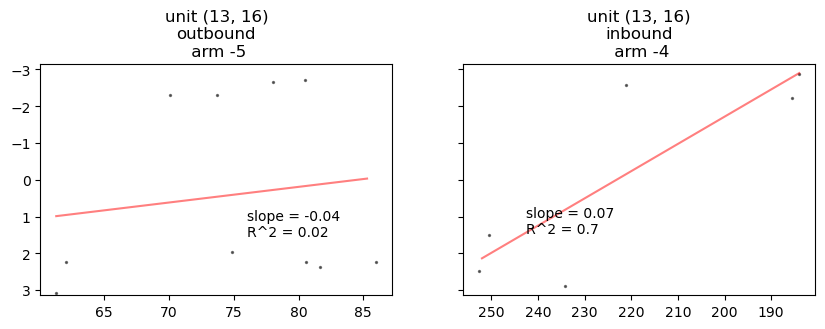

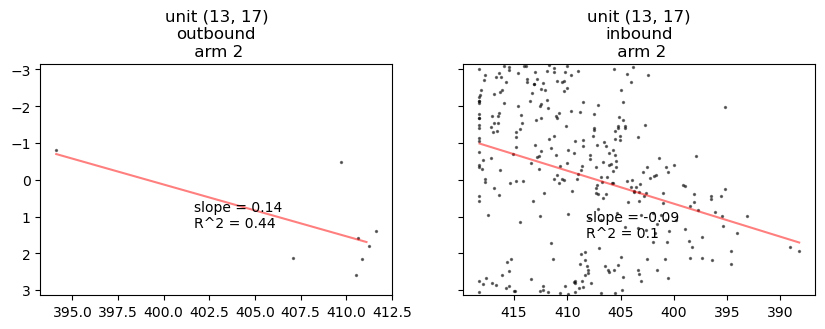

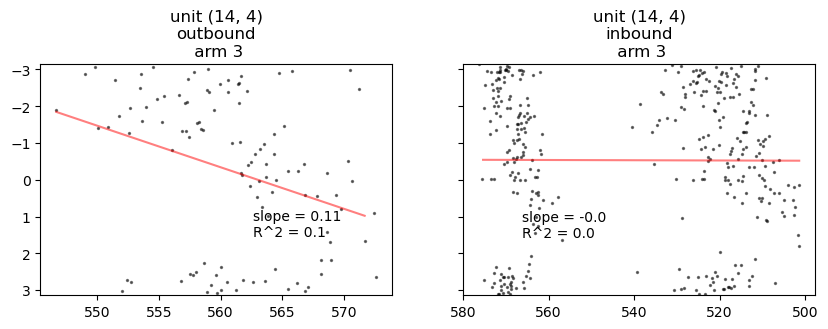

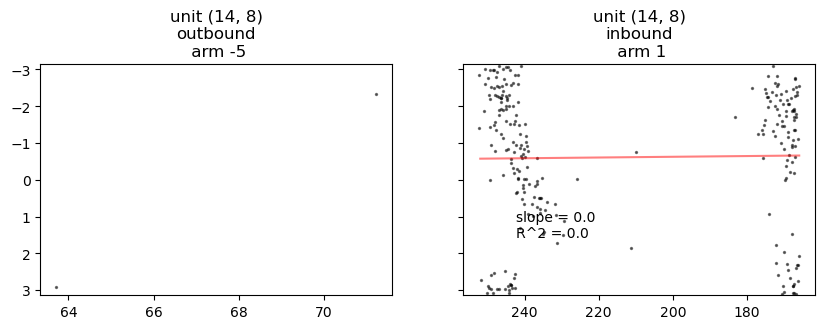

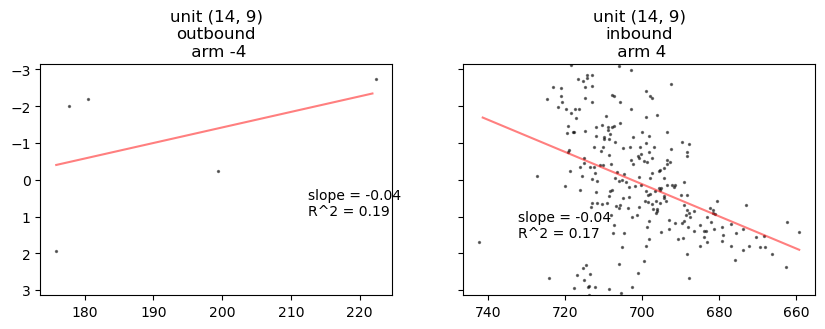

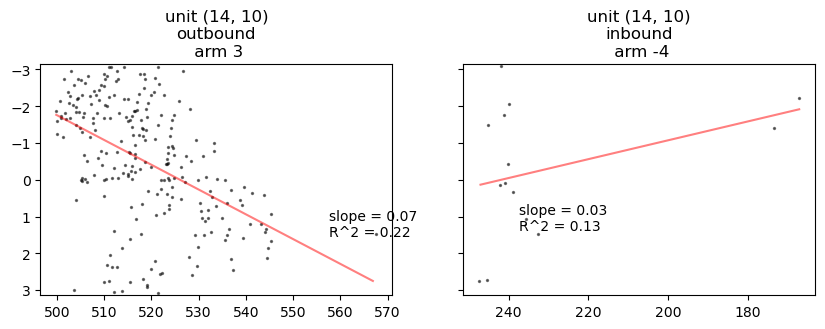

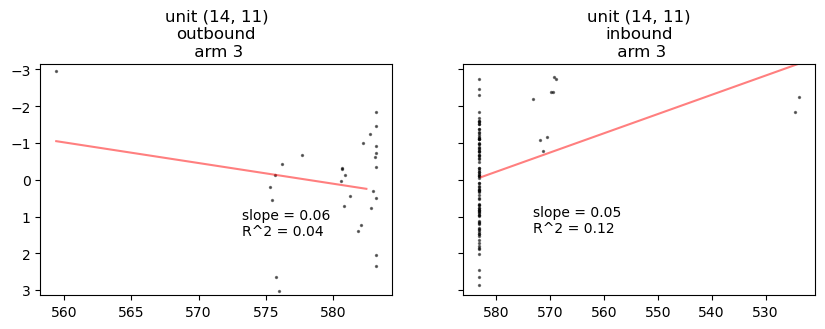

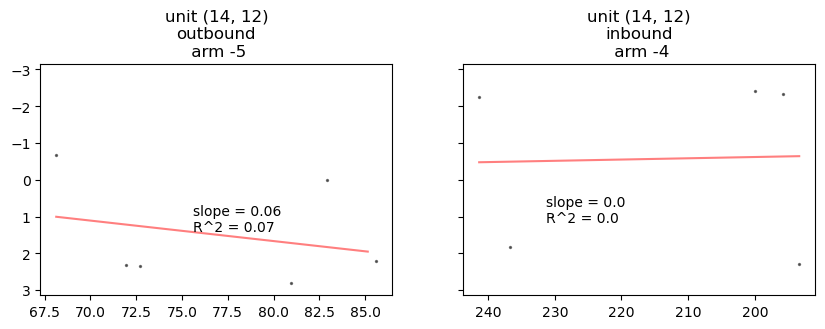

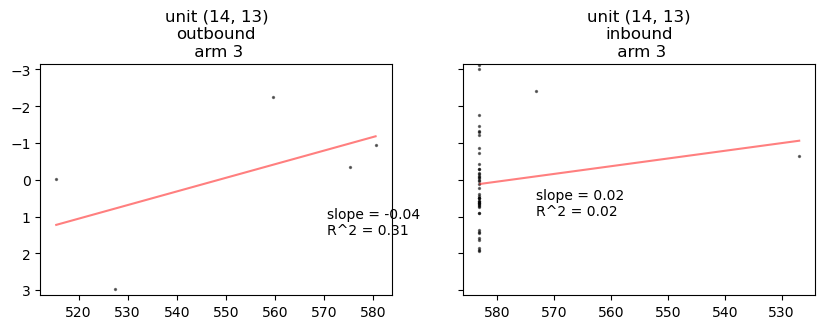

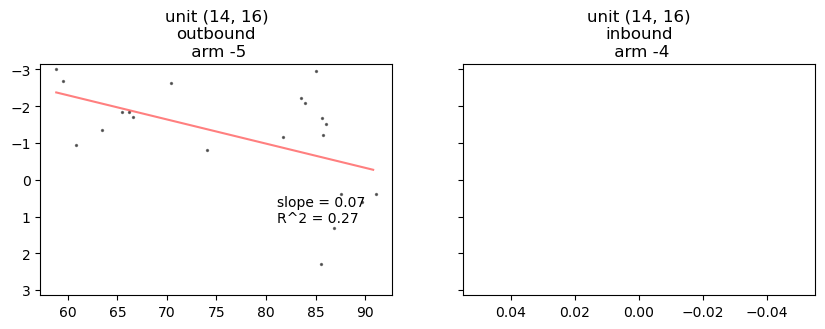

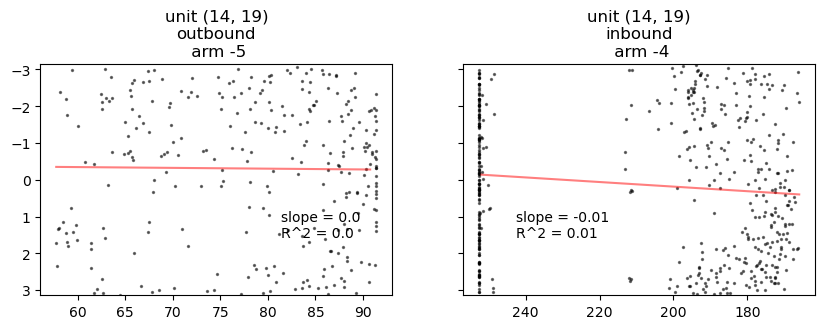

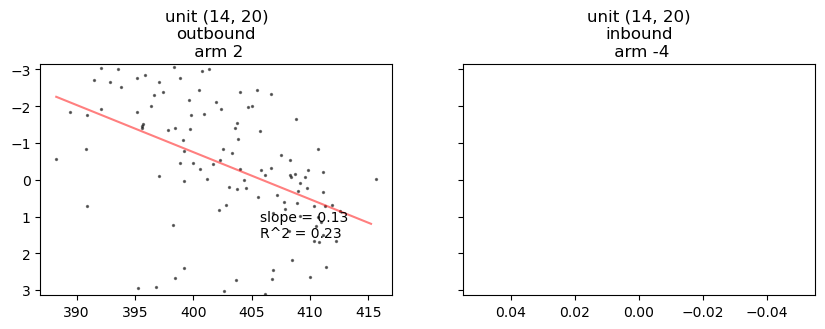

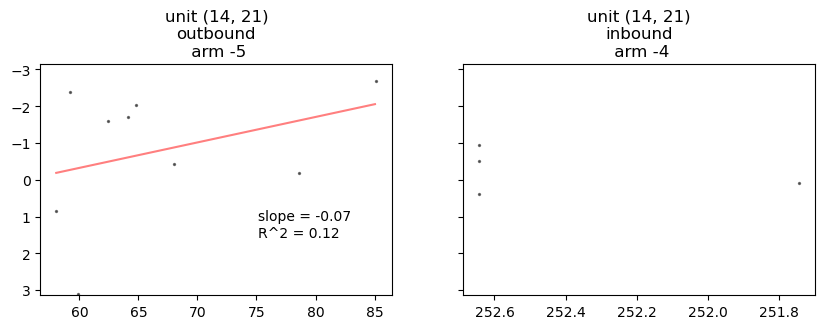

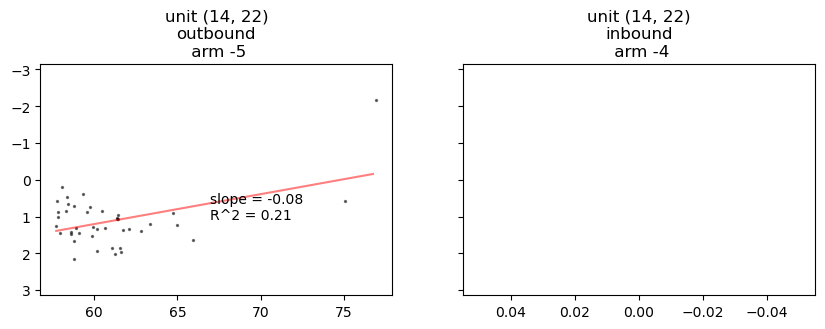

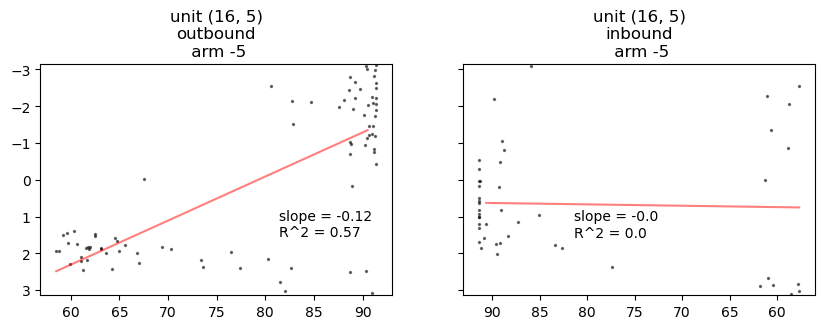

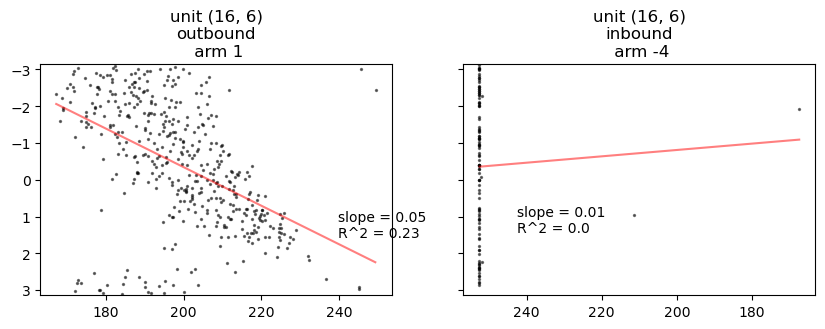

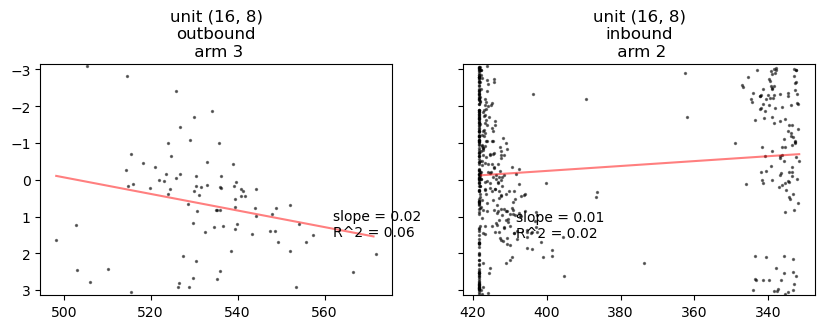

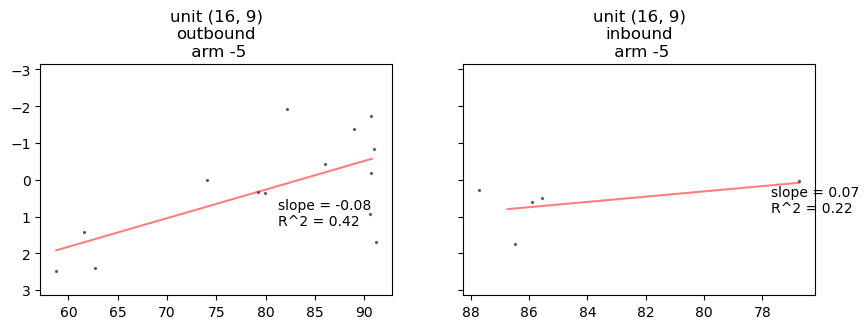

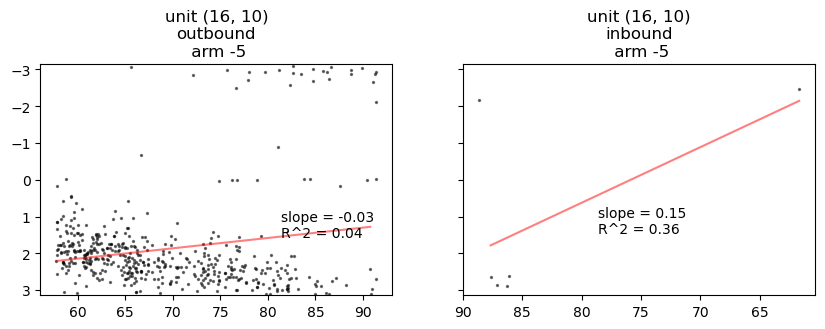

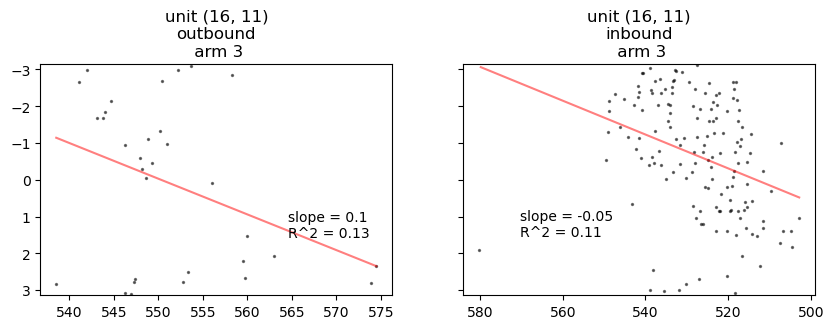

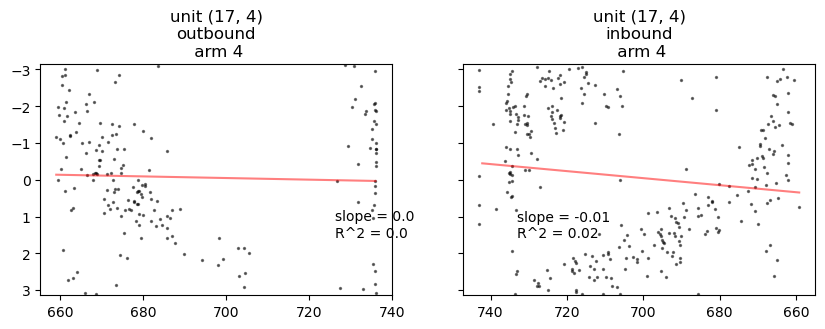

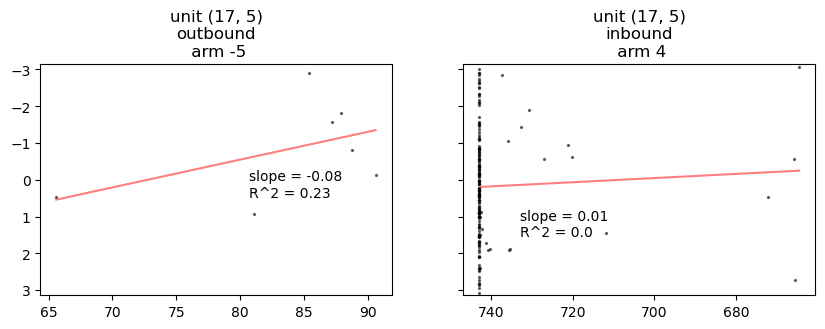

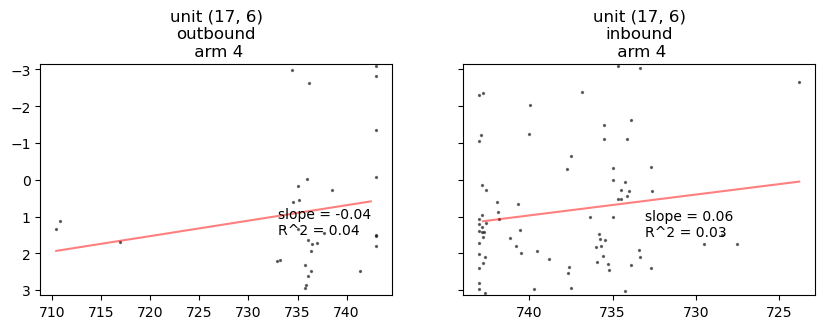

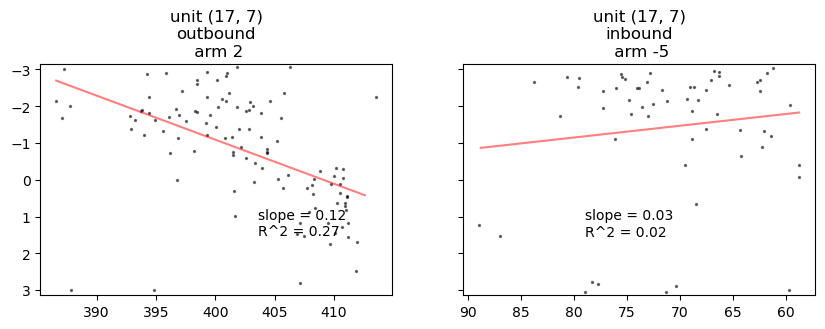

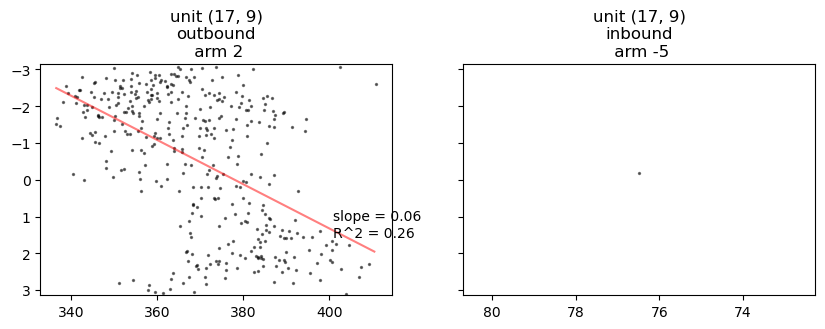

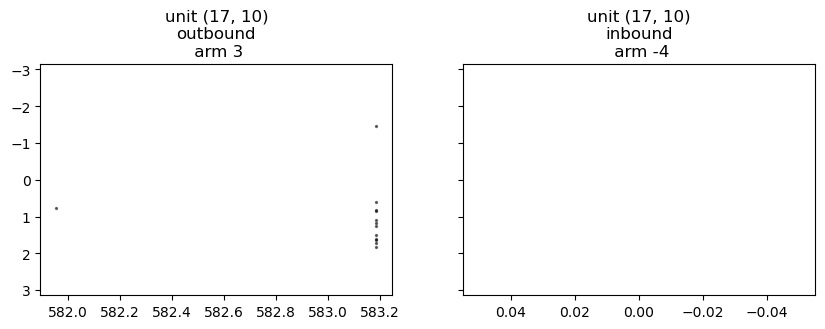

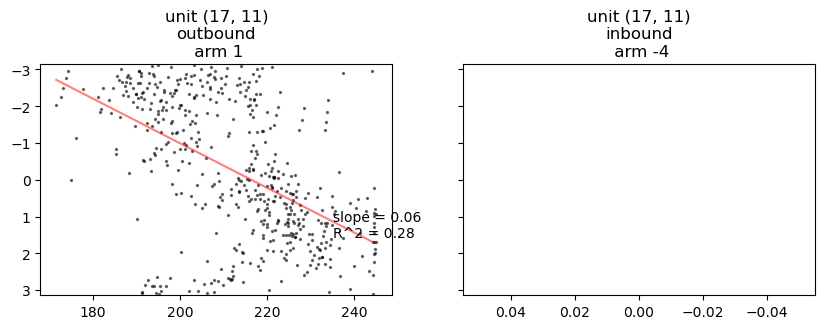

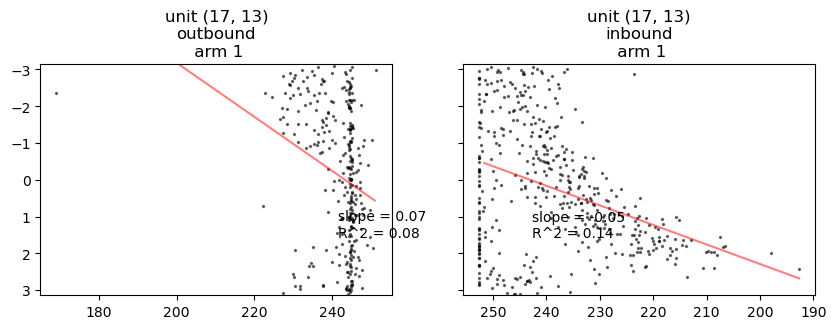

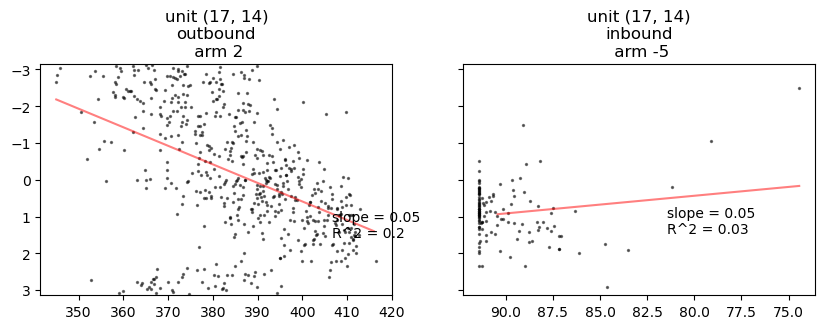

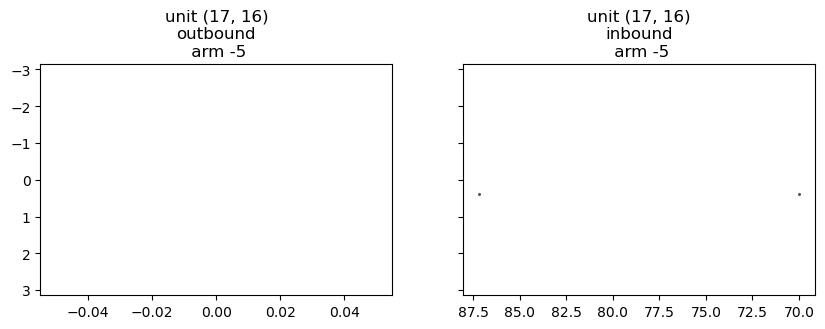

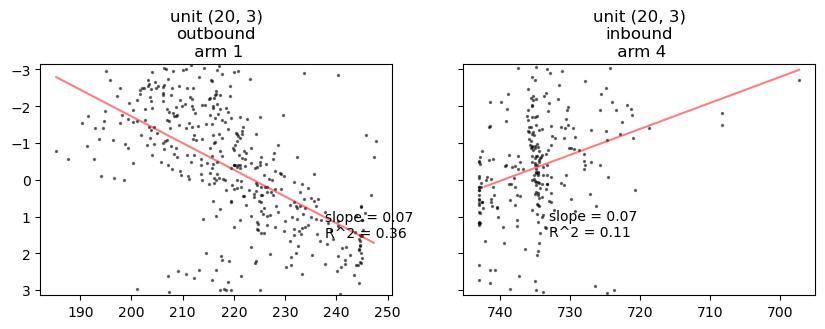

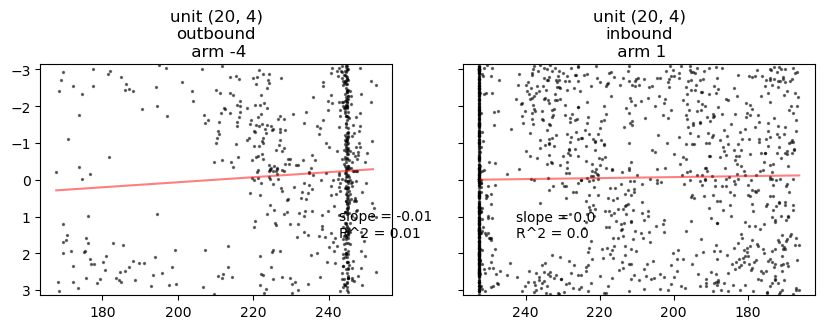

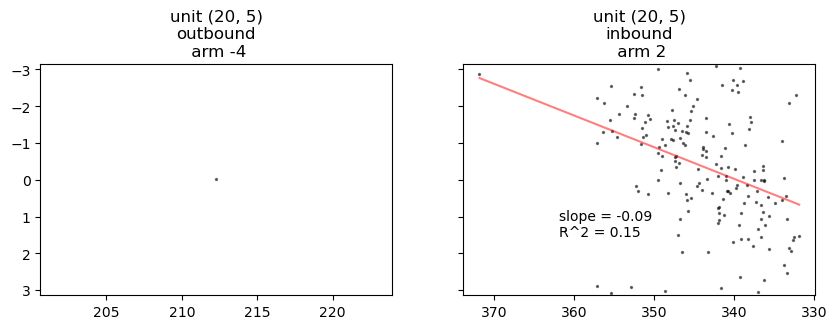

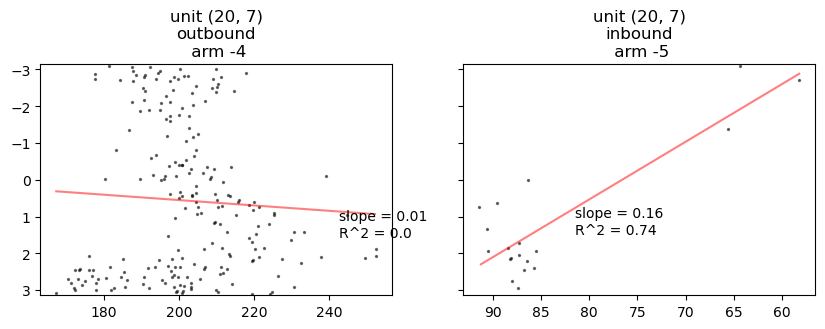

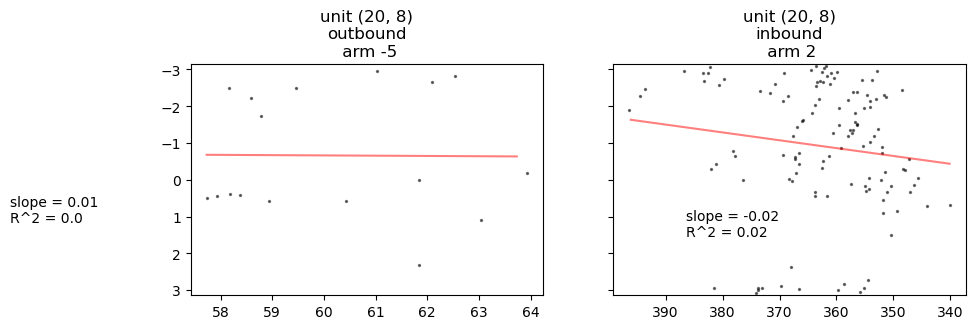

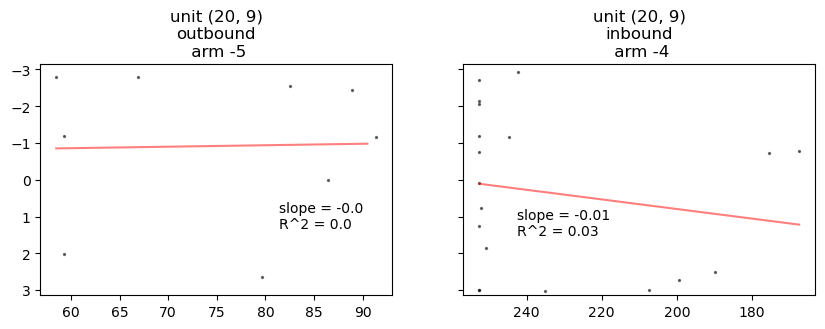

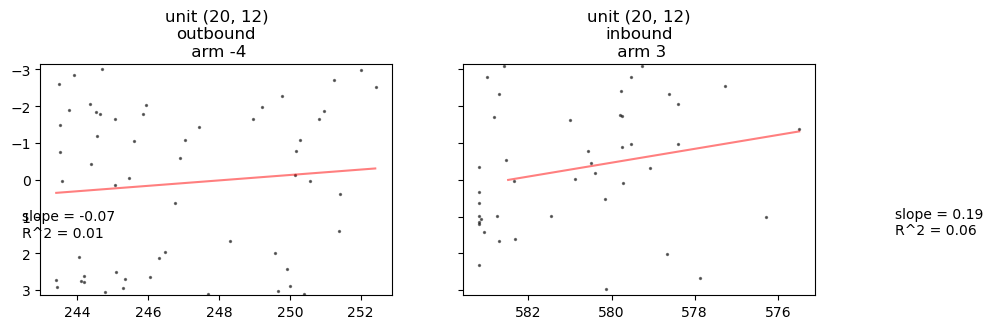

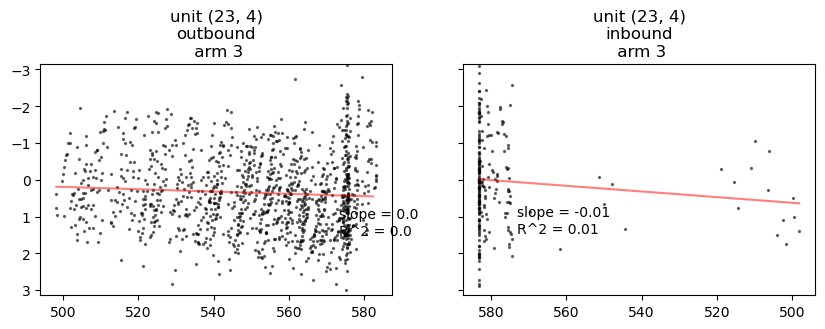

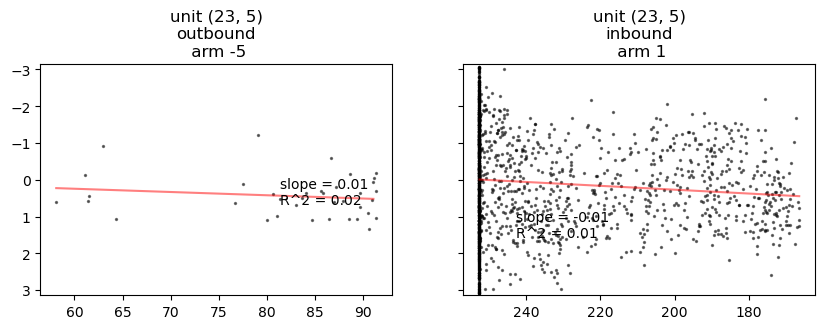

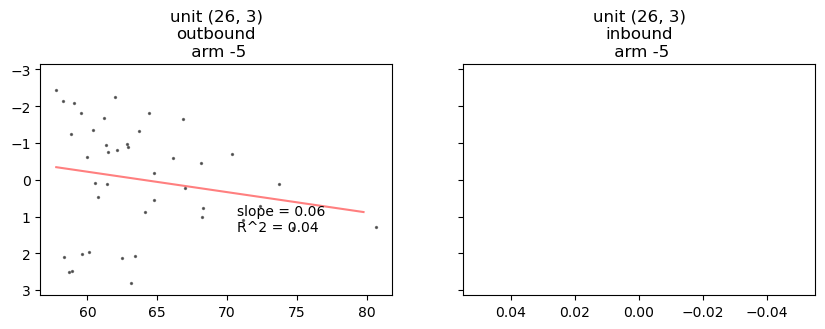

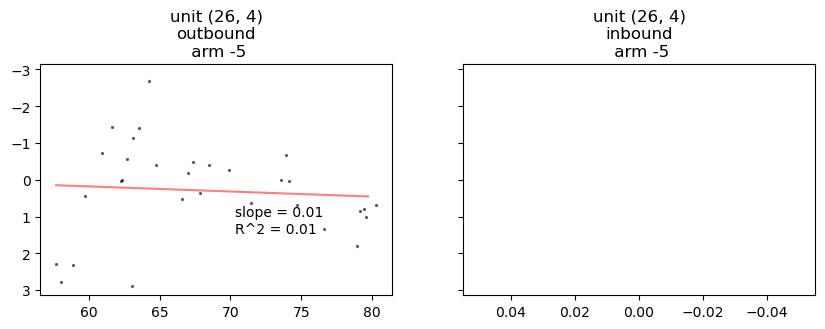

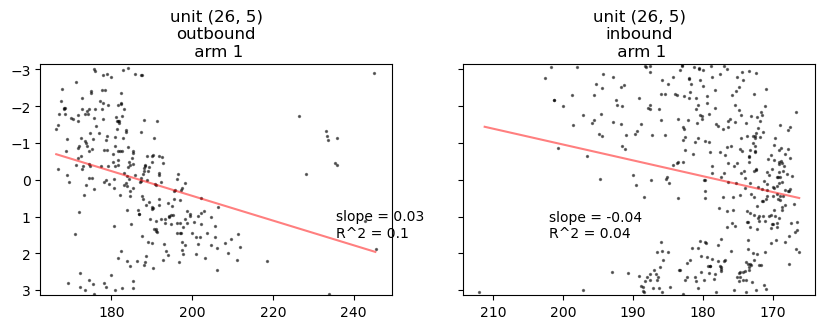

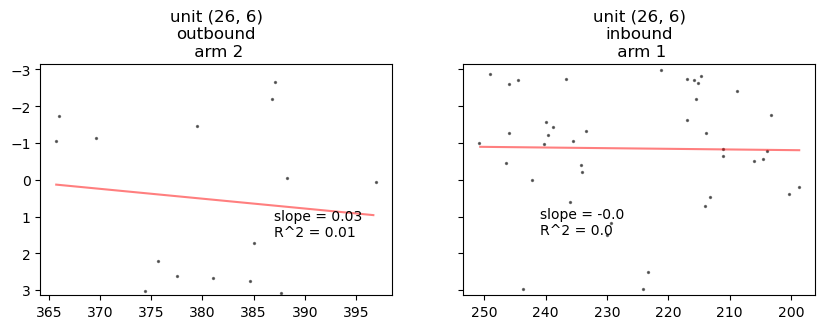

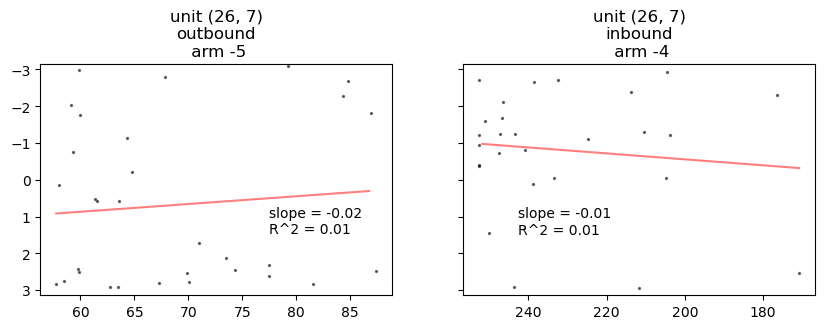

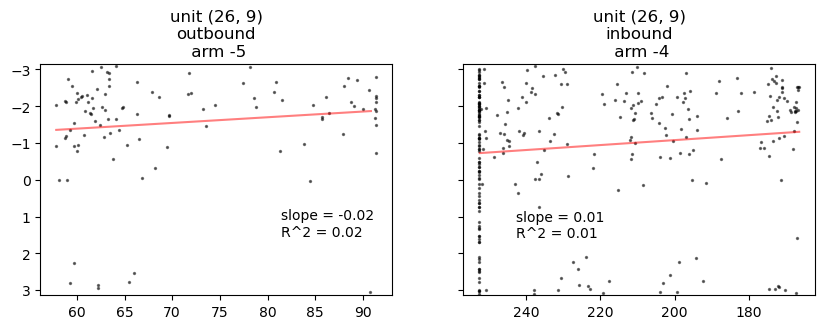

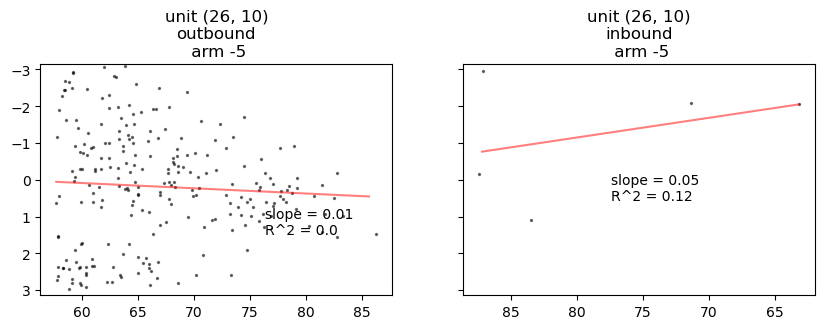

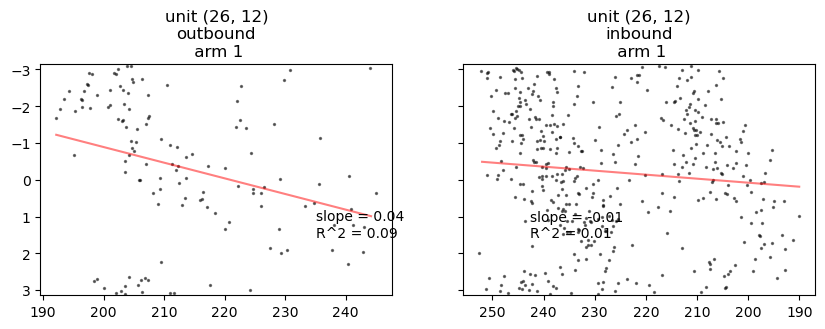

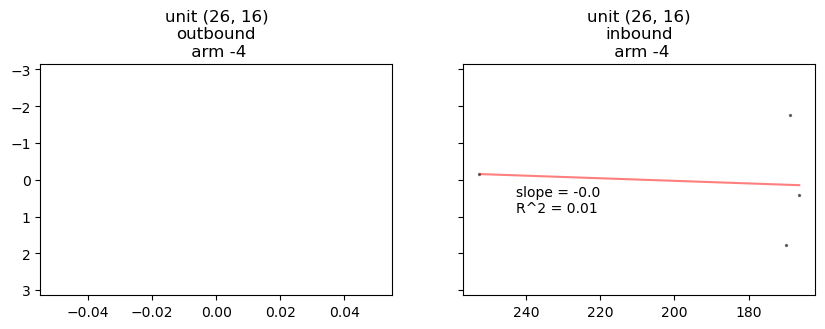

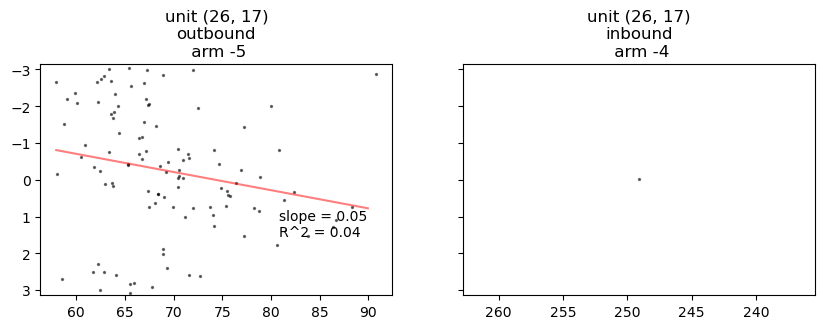

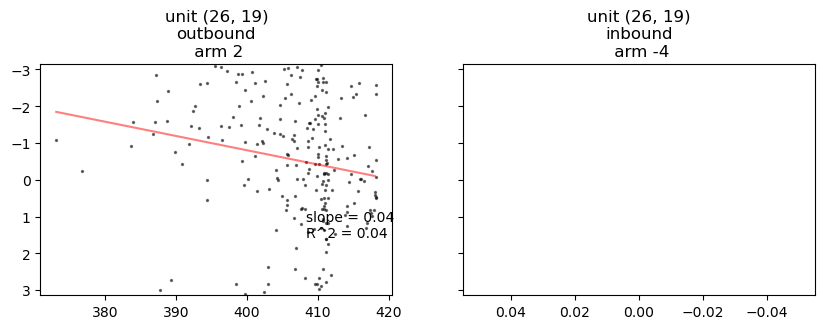

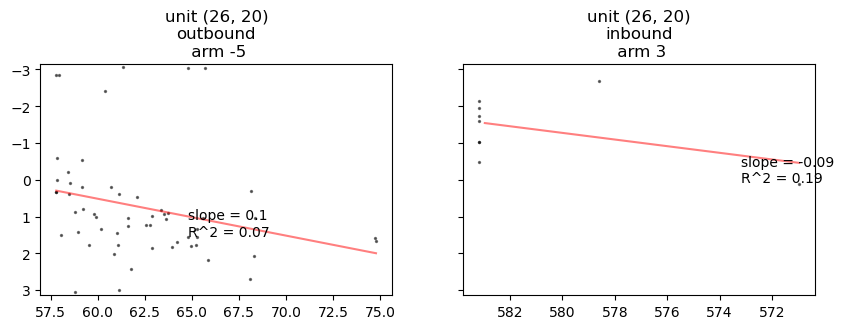

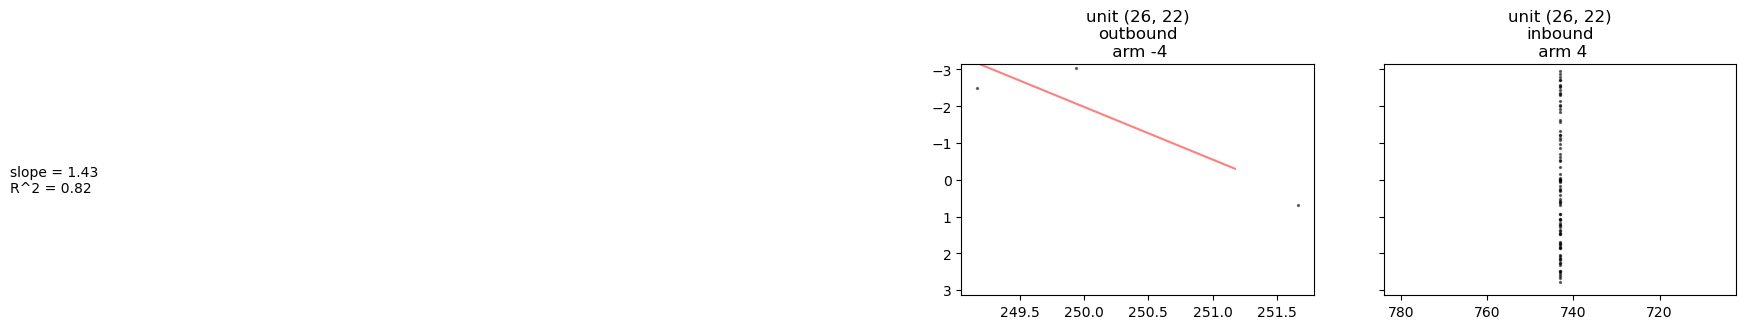

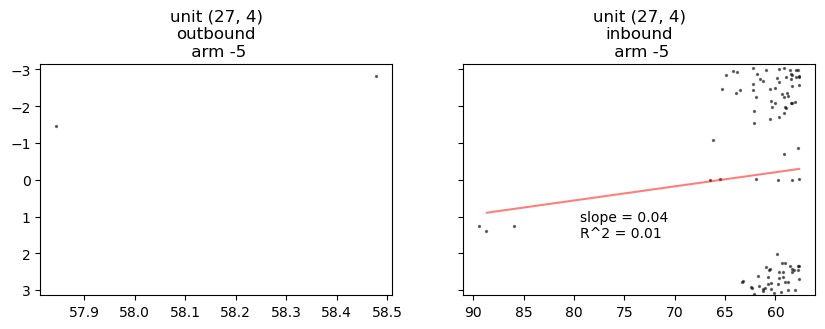

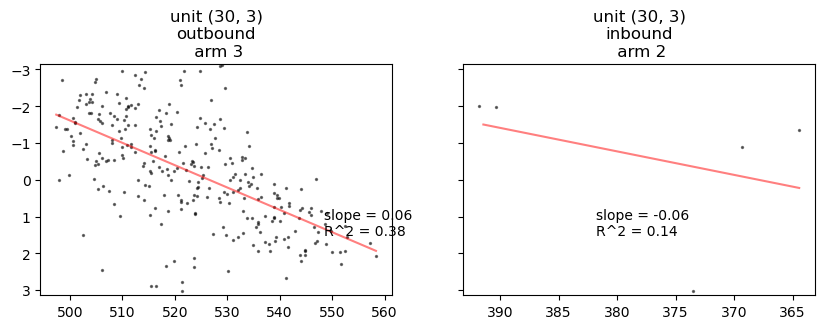

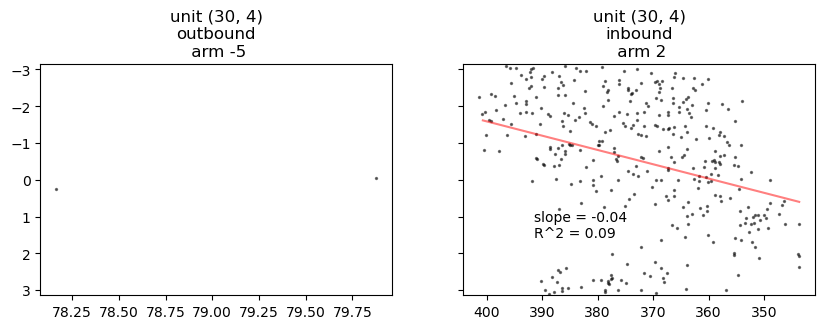

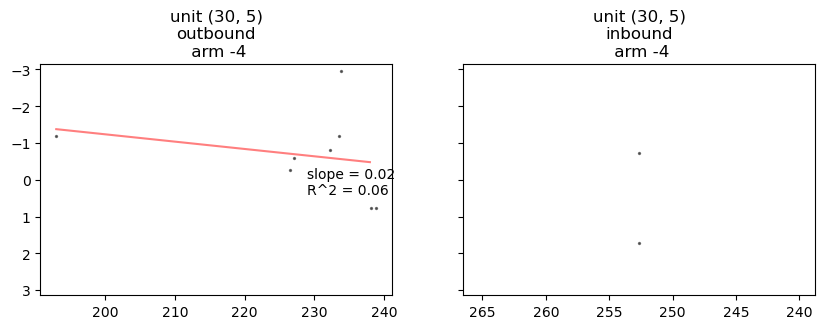

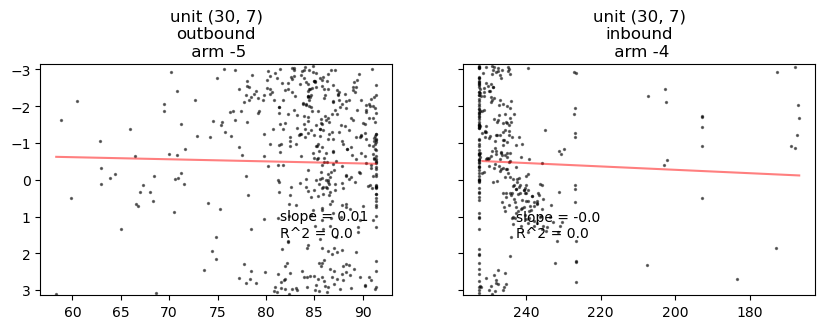

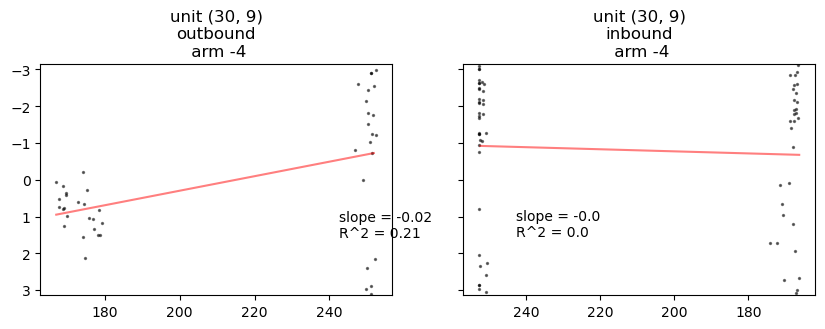

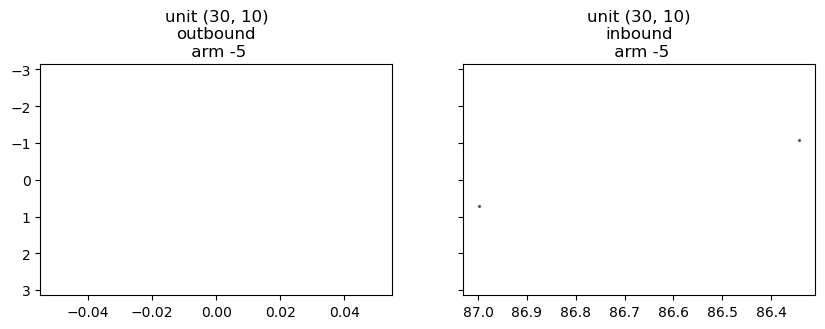

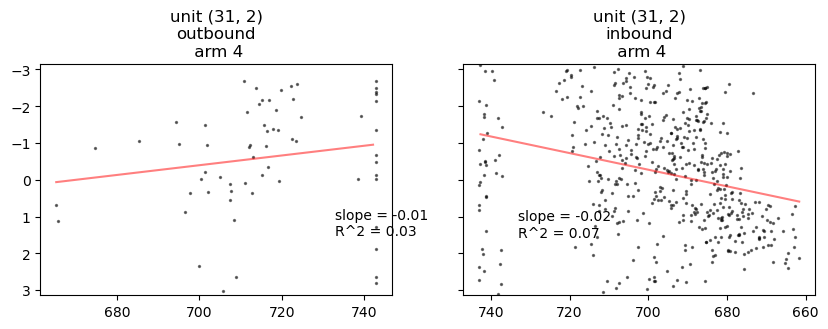

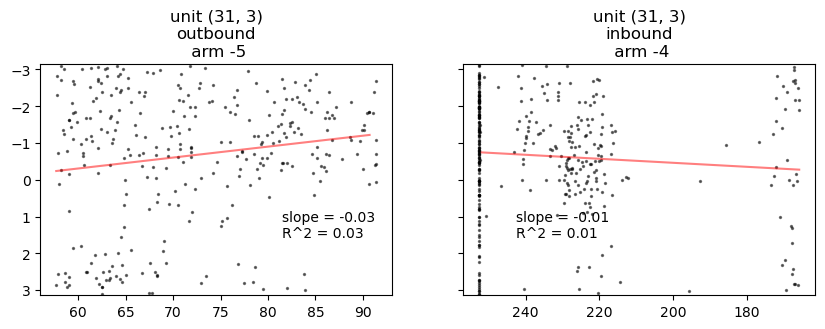

In [114]:
coef_all_cont = []
score_all_cont = []

for unitID in cell_list:
    pos_phase,arms = return_theta_phase_location(pos1d,pos2d,theta_df,nwb_units_all,unitID)
    model,score = fit_theta_phase_location(pos_phase,arms)

    # find direction
    scores = np.array([score['outbound'],score['inbound']])
    if np.sum(np.isnan(scores)) == 2:
        continue
    direction = np.nanargmax(scores)
    if direction == 0:
        coef = model['outbound'].coef_[0][0]
    else:
        coef = -model['inbound'].coef_[0][0]
    
    score_all_cont.append(scores[direction])
    coef_all_cont.append(coef)

    # plot
    plot_theta_phase_precession(pos_phase,arms,model,score,unitID)

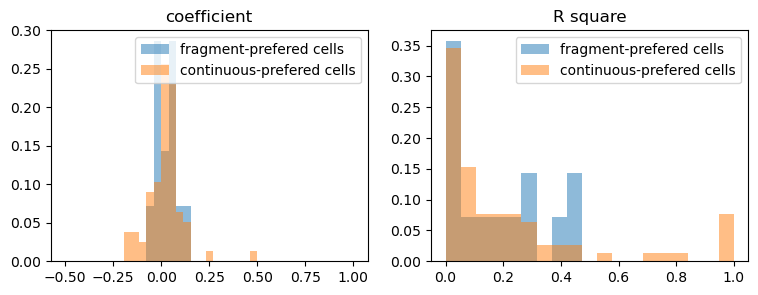

In [115]:
fig, axes = plt.subplots(1,2,figsize = (9,3))

for i in range(2):
    if i == 0:
        data1 = coef_all_frag
        data2 = coef_all_cont
        title = 'coefficient'
        bins_ = np.linspace(-0.5,1,40)
    elif i == 1:
        data1 = score_all_frag
        data2 = score_all_cont
        title = 'R square'
        bins_ = np.linspace(0,1,20)
 
    axes[i].hist(data1,bins = bins_,alpha = 0.5,
             weights = np.ones(len(data1))/len(data1), label = 'fragment-prefered cells')
    axes[i].hist(data2,bins = bins_,alpha = 0.5,
             weights = np.ones(len(data2))/len(data2), label = 'continuous-prefered cells')
    axes[i].set_title(title);
    
    #axes[i].set_xticks(np.arange(0,80,10)+0.5);
    #axes[i].set_xticklabels(np.arange(0,80,10));
    axes[i].legend()